# Take Raw_Recipe Dataset and find 15 most significant recipe clusters

In [ ]:
import openai
import matplotlib.pyplot as plt
import pandas as pd
import ast
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from dotenv import load_dotenv

In [ ]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
openai.api_key = api_key

In [6]:
data_count=10000
k_clusters = 15

food_recipe_df = pd.read_csv('RAW_recipes.csv')
# Convert string lists to actual lists and clean up text
recipes = food_recipe_df['ingredients'].tolist()
cleaned_recipes = [" ".join(ast.literal_eval(recipe)) for recipe in recipes]
cleaned_recipes = cleaned_recipes[0:data_count]

In [7]:
def sanitize(list_of_lists):
    '''filter out blacklisted words from a given list of lists
    '''
    filtered_words = ['ground', 'fresh', 'frozen', 'prepared', 'patty', 'unsalted', 'salted', 'all purpose', 'all-purpose', 'boneless', 'skinless', 'halves', 'extra', 'virgin', 'powder', 'cube', 'diced', 'dried', 'light', 'prepared', 'stone-ground']

    sanitized_list = []

    for list in list_of_lists:
        words = list.split()  # Split ingredient name into words
        cleaned_words = [word for word in words if word.lower() not in filtered_words]
        sanitized_list.append(" ".join(cleaned_words))  # Rejoin into a string

    return sanitized_list

In [ ]:
# Convert string lists to actual lists and clean up text
recipes = food_recipe_df['ingredients'].tolist()

sorted_recipes = []  # Store sorted ingredient lists

for row in recipes:
    ingredient_list = ast.literal_eval(row)  # Convert string to list
    ingredient_list.sort()  # Sort ingredients in place
    sorted_recipes.append(", ".join(sanitize(ingredient_list)))  # Store the sorted list

cleaned_recipes = sorted_recipes[0:data_count]  # Sample 50,000 recipes for faster processing

batch_size = 10  # Adjust batch size as needed
embedding_str_to_int = {}
recipe_list_embeddings = []

#for each "cleaned recipe"(took out some unnecessary words in ingredients) 
#go through the recipe and build a list of ingredient vectors using a language embedding
#sped this up by using a dictionary between found word and its embedding and check this hashtable before making a call to openai to get the language embedding
for i in range(0, len(cleaned_recipes), batch_size):
    batch = cleaned_recipes[i:i + batch_size]
    ingredients = []
    for recipe in batch:
        for ingredient in recipe.split():
            if ingredient not in embedding_str_to_int:
                ingredients.append(ingredient)
    
    if ingredients:
        response = openai.Embedding.create(input=ingredients, model="text-embedding-ada-002")
        for idx, ingredient in enumerate(ingredients):
            embedding_str_to_int[ingredient] = response['data'][idx]['embedding']
    
    for recipe in batch:
        converted_recipe = []
        for ingredient in recipe.split():
            converted_recipe.append(embedding_str_to_int[ingredient])
        recipe_list_embeddings.append(converted_recipe)

# recipe_list_embeddings contains a list of recipes that have had their words converted into embeddings

# Create a reduced dataframe for the first 50,000 rows
food_recipe_df_reduced = food_recipe_df.head(data_count)

# Ensure each recipe is converted to a single 1536-dimensional vector
recipe_embeddings = []
embedding_dim = 1536  # text-embedding-ada-002 output size

for recipe in recipe_list_embeddings:
    if recipe:  # If the recipe has ingredient embeddings
        recipe_embeddings.append(np.mean(recipe, axis=0))  # Take mean of ingredient embeddings
    else:
        recipe_embeddings.append(np.zeros(embedding_dim))  # Assign zero vector for empty recipes

# Convert list to NumPy array (fixed shape)
recipe_embeddings = np.array(recipe_embeddings)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
food_recipe_df_reduced['cluster'] = kmeans.fit_predict(recipe_embeddings[:data_count])

C:\Users\donal\AppData\Local\Temp\ipykernel_12228\646695656.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df_reduced['cluster'] = kmeans.fit_predict(recipe_embeddings[:data_count])


# Use PCA to reduce dimensionality to 2D to graph clusters as a visualization

In [ ]:
# Define cluster names, used cluster_recipe.txt output and asked copilot to assign categories to the clusters and inputted those here.
cluster_names = {
0: "Beverages and Cocktails",
1: "Main Dishes and Soups",
2: "Baked Goods and Desserts",
3: "Sauces and Seasonings",
4: "Asian-inspired Dishes",
5: "Sweet Snacks and Treats",
6: "Frozen Desserts and Sweet Drinks",
7: "Savory Dishes with Vegetables and Meats",
8: "Fruit-based Dishes and Drinks",
9: "Desserts with Spices and Fruits",
10: "Baked Goods and Breakfast Items",
11: "Soups and Stews",
12: "Cheese-based Dishes and Casseroles",
13: "Various Baked and Savory Goods",
14: "Savory Dishes with Meat and Eggs"
}
food_recipe_df_reduced['category'] = food_recipe_df_reduced['cluster'].map(cluster_names)

C:\Users\donal\AppData\Local\Temp\ipykernel_12228\1643749633.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_recipe_df_reduced['category'] = food_recipe_df_reduced['cluster'].map(cluster_names)


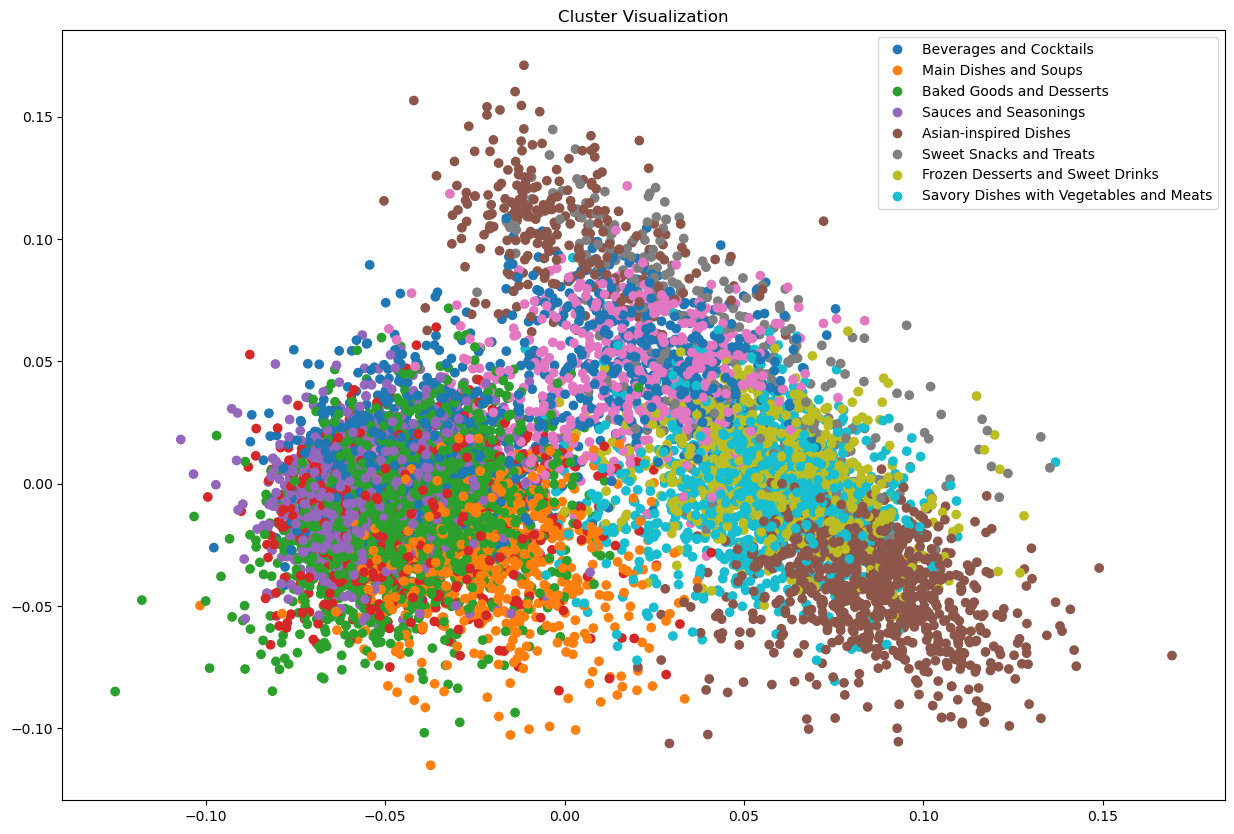

['Beverages and Cocktails', 'Main Dishes and Soups', 'Baked Goods and Desserts', 'Sauces and Seasonings', 'Asian-inspired Dishes', 'Sweet Snacks and Treats', 'Frozen Desserts and Sweet Drinks', 'Savory Dishes with Vegetables and Meats', 'Fruit-based Dishes and Drinks', 'Desserts with Spices and Fruits', 'Baked Goods and Breakfast Items', 'Soups and Stews', 'Cheese-based Dishes and Casseroles', 'Various Baked and Savory Goods', 'Savory Dishes with Meat and Eggs']


In [10]:
# Apply PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(recipe_embeddings)  # Use X (TF-IDF) for PCA, not the DataFrame

# Scatter plot of clusters
plt.figure(figsize=(15, 10))

scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=food_recipe_df_reduced['cluster'], cmap='tab10')

plt.title("Cluster Visualization")
# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, list(cluster_names.values()))

plt.show()
print(list(cluster_names.values()))

## Add Cluster Names provided by Copilot to describe the clusters

## Output first 50 recipes from each cluster

In [ ]:
# Open a text file for writing the output
with open("clustered_recipes.txt", "w") as file:
    for i in range(k_clusters):
        file.write(f"{food_recipe_df_reduced[food_recipe_df_reduced['cluster'] == i]['category'].head(1)})\n")
        top_recipes = food_recipe_df_reduced[food_recipe_df_reduced['cluster'] == i]['ingredients'].head(50)
        for recipe in top_recipes:
            sorted_recipe = ast.literal_eval(recipe)
            sorted_recipe = sorted(sorted_recipe)
            file.write(f"{sorted_recipe}\n")  # Write each recipe in the cluster
        file.write("\n")  # Add a blank line between clusters